# Advanced Tutorial 8: Explainable AI (XAI)

## Overview
In this tutorial, we will discuss the following topics:
* [Saliency Maps](#ta08saliency)
    * [With Traces](#ta08with)
    * [Without Traces](#ta08without)
* [Label Tracking](#ta08labels)
* [Instance Tracking](#ta08instance)

We'll start by getting the imports out of the way:

In [1]:
import tempfile
import os

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import squeeze, reduce_mean
from fastestimator.dataset.data import cifair10
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop import LambdaOp
from fastestimator.schedule import RepeatScheduler
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver, ImageViewer, TensorBoard
from fastestimator.trace.metric import MCC
from fastestimator.trace.xai import Saliency, LabelTracker, InstanceTracker
from fastestimator.util import to_number

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import numpy as np

label_mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

<a id='ta08saliency'></a>

## Saliency Maps

Suppose you have a neural network that is performing image classification. The network tells you that the image it is looking at is an airplane, but you want to know whether it is really detecting an airplane, or if it is 'cheating' by noticing the blue sky in the image background. To answer this question, all you need to do is add the `Saliency` `Trace` to your list of traces, and pass its output to one of either the `ImageSaver`, `ImageViewer`, or `TensorBoard` `Traces`.

<a id='ta08with'></a>

In [2]:
batch_size=128
save_dir = tempfile.mkdtemp()

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(range(len(eval_data) // 2))
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
         PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
         RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
         Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
         CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
         ],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    MCC(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    RepeatScheduler([Saliency(model=model,
                             model_inputs="x",
                             class_key="y",
                             model_outputs="y_pred",
                             samples=5,
                             label_mapping=label_mapping),
                     None, None, None, None]),  # Only compute Saliency every 5 epochs for cleaner logs
    RepeatScheduler([ImageViewer(inputs="saliency"), None, None, None, None])  # Only display the images every 5 epochs for cleaner logs
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=21,
                         traces=traces,
                         log_steps=300)

In this example we will be using the `ImageViewer` `Trace`, since it will allow us to visualize the outputs within this Notebook. If you wanted your images to appear in TensorBoard, simply construct a `TensorBoard` `Trace` with the "write_images" argument set to "saliency". 

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.299914;
FastEstimator-Train: step: 300; ce: 1.4924866; steps/sec: 24.93;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 16.59 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5


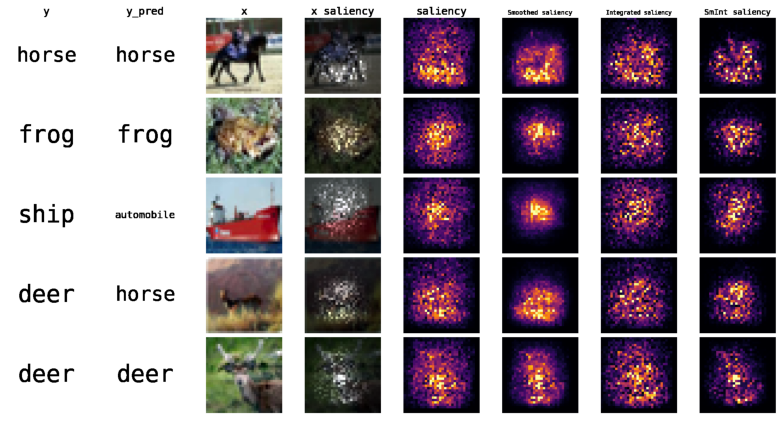

FastEstimator-Eval: step: 391; epoch: 1; ce: 1.2723362; max_mcc: 0.48628830256323324; mcc: 0.48628830256323324; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 1.2124541; steps/sec: 23.76;
FastEstimator-Train: step: 782; epoch: 2; epoch_time: 17.39 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Eval: step: 782; epoch: 2; ce: 1.160483; max_mcc: 0.5373354909919813; mcc: 0.5373354909919813; since_best_mcc: 0;
FastEstimator-Train: step: 900; ce: 1.2837203; steps/sec: 21.33;
FastEstimator-Train: step: 1173; epoch: 3; epoch_time: 18.58 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Eval: step: 1173; epoch: 3; ce: 1.0487616; max_mcc: 0.5839187875695295; mcc: 0.5839187875695295; since_best_mcc: 0;
FastEstimator-Train: step: 1200; ce: 1.085485; steps/sec: 20.98;
FastEstimator-Train: step: 1500; ce: 

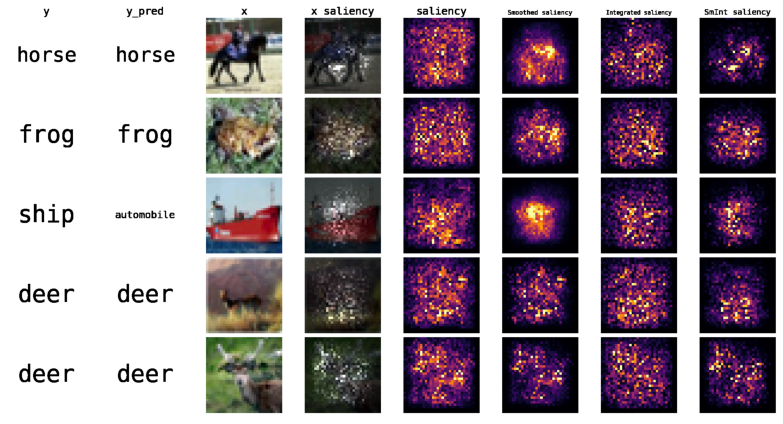

FastEstimator-Eval: step: 2346; epoch: 6; ce: 0.8742531; max_mcc: 0.6536016428546363; mcc: 0.6536016428546363; since_best_mcc: 0;
FastEstimator-Train: step: 2400; ce: 0.93692327; steps/sec: 19.82;
FastEstimator-Train: step: 2700; ce: 0.8163053; steps/sec: 20.15;
FastEstimator-Train: step: 2737; epoch: 7; epoch_time: 19.61 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Eval: step: 2737; epoch: 7; ce: 0.84662104; max_mcc: 0.6714150425757782; mcc: 0.6714150425757782; since_best_mcc: 0;
FastEstimator-Train: step: 3000; ce: 0.9238768; steps/sec: 19.46;
FastEstimator-Train: step: 3128; epoch: 8; epoch_time: 19.54 sec;
FastEstimator-Eval: step: 3128; epoch: 8; ce: 0.86339396; max_mcc: 0.6714150425757782; mcc: 0.6600460749701773; since_best_mcc: 1;
FastEstimator-Train: step: 3300; ce: 0.8765948; steps/sec: 21.83;
FastEstimator-Train: step: 3519; epoch: 9; epoch_time: 18.3 sec;
FastEstimator-BestMode

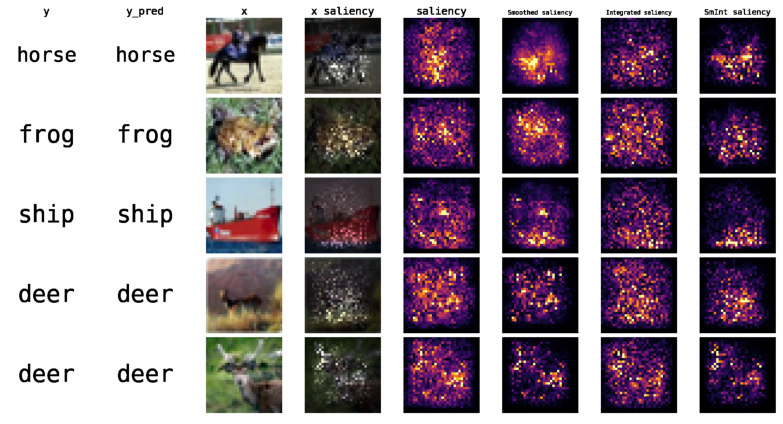

FastEstimator-Eval: step: 4301; epoch: 11; ce: 0.7510463; max_mcc: 0.7045564039822207; mcc: 0.7045564039822207; since_best_mcc: 0;
FastEstimator-Train: step: 4500; ce: 0.9140001; steps/sec: 19.6;
FastEstimator-Train: step: 4692; epoch: 12; epoch_time: 20.07 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Eval: step: 4692; epoch: 12; ce: 0.7310184; max_mcc: 0.7092443273007975; mcc: 0.7092443273007975; since_best_mcc: 0;
FastEstimator-Train: step: 4800; ce: 0.57807827; steps/sec: 19.17;
FastEstimator-Train: step: 5083; epoch: 13; epoch_time: 21.03 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Eval: step: 5083; epoch: 13; ce: 0.73153687; max_mcc: 0.7183247894818372; mcc: 0.7183247894818372; since_best_mcc: 0;
FastEstimator-Train: step: 5100; ce: 0.76966476; steps/sec: 18.52;
FastEstimator-Train: step

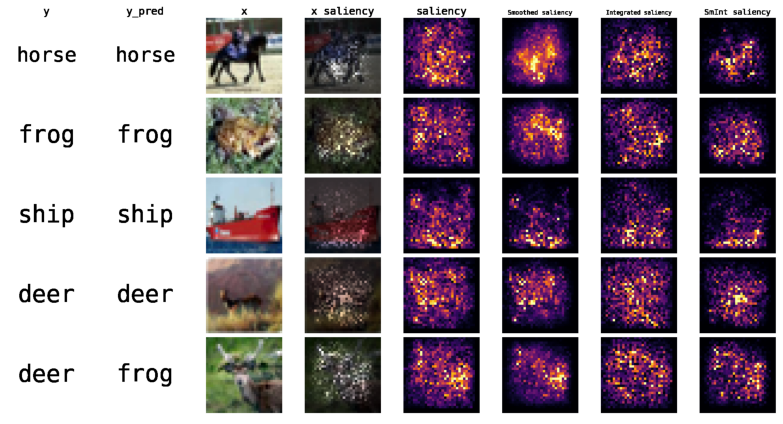

FastEstimator-Eval: step: 6256; epoch: 16; ce: 0.68356884; max_mcc: 0.7334378906959268; mcc: 0.7334378906959268; since_best_mcc: 0;
FastEstimator-Train: step: 6300; ce: 0.7207744; steps/sec: 19.54;
FastEstimator-Train: step: 6600; ce: 0.7227626; steps/sec: 20.52;
FastEstimator-Train: step: 6647; epoch: 17; epoch_time: 19.07 sec;
FastEstimator-Eval: step: 6647; epoch: 17; ce: 0.7133687; max_mcc: 0.7334378906959268; mcc: 0.7276643934081581; since_best_mcc: 1;
FastEstimator-Train: step: 6900; ce: 0.6817666; steps/sec: 19.98;
FastEstimator-Train: step: 7038; epoch: 18; epoch_time: 19.74 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Eval: step: 7038; epoch: 18; ce: 0.67803246; max_mcc: 0.7354524938584647; mcc: 0.7354524938584647; since_best_mcc: 0;
FastEstimator-Train: step: 7200; ce: 0.67648566; steps/sec: 19.93;
FastEstimator-Train: step: 7429; epoch: 19; epoch_time: 19.94 sec;
FastEstimator-B

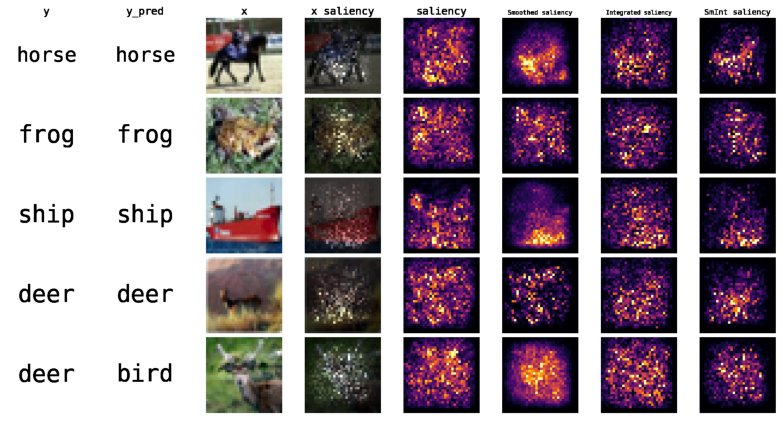

FastEstimator-Eval: step: 8211; epoch: 21; ce: 0.68232316; max_mcc: 0.7515969479078255; mcc: 0.7389785175501096; since_best_mcc: 2;
FastEstimator-BestModelSaver: Restoring model from /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmppsjegvu2/model_best_mcc.h5
FastEstimator-Finish: step: 8211; model_lr: 0.001; total_time: 461.31 sec;


In [3]:
estimator.fit()

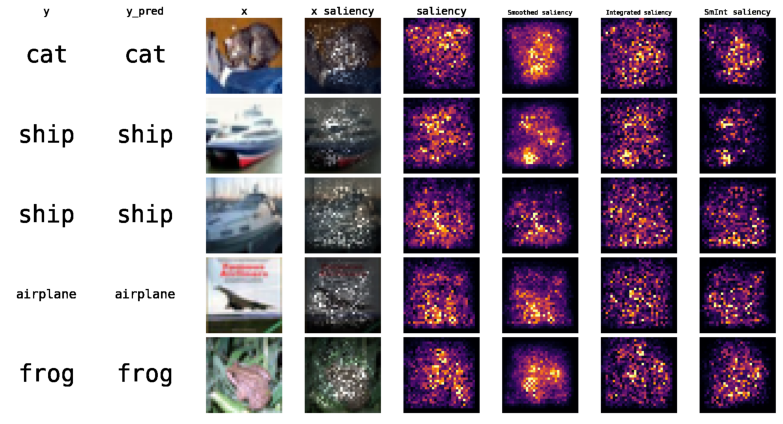

FastEstimator-Test: step: 8211; epoch: 21; ce: 0.70077264; mcc: 0.7407569506915119;


In [4]:
estimator.test()

In the images above, the 'saliency' column corresponds to a raw saliency mask generated by back-propagating a model's output prediction onto the input image. 'Smoothed saliency' combines multiple saliency masks for each image 'x', where each mask is generated by slightly perturbing the input 'x' before running the forward and backward gradient passes. The number of samples to be combined is controlled by the "smoothing" argument in the `Saliency` `Trace` constructor. 'Integrated saliency' is a saliency mask generated by starting from a baseline noise image and linearly interpolating the image towards 'x' over a number of steps defined by the "integrating" argument in the Saliency constructor. The resulting masks are then combined together. The 'SmInt Saliency' (Smoothed-Integrated) column combines smoothing and integration together. SmInt is generally considered to give the most reliable indication of the important features in an image, but it also takes the longest to compute. It is possible to disable the more complex columns by setting the 'smoothing' and 'integrating' parameters to 0. The 'x saliency' column shows the input image overlaid with whatever saliency column is furthest to the right (SmInt, unless that has been disabled).

<a id='ta08without'></a>

## Saliency Maps without Traces

Suppose that you want to generate Saliency masks without using a `Trace`. This can be done through the fe.xai package:

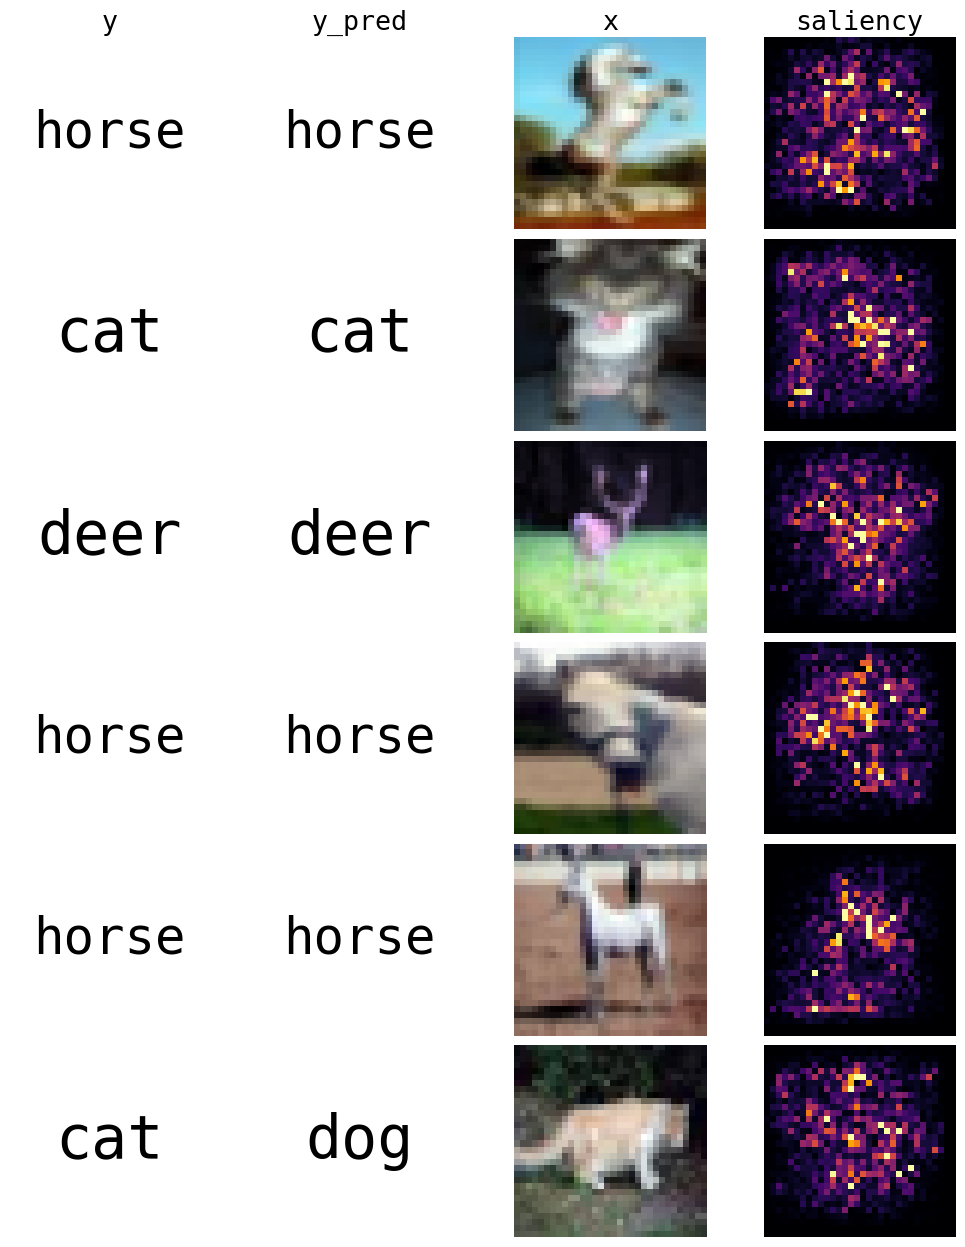

In [5]:
pipeline.batch_size = 6
batch = pipeline.get_results(num_steps=2, mode='eval')[1] # Get some images we didn't see already above
batch = fe.backend.to_tensor(batch, "tf")  # Convert the batch to TensorFlow

saliency_generator = fe.xai.SaliencyNet(model=model, model_inputs="x", model_outputs="y_pred")
images = saliency_generator.get_smoothed_masks(batch=batch, nsamples=6, nintegration=100)

# Let's convert 'y' and 'y_pred' from numeric values to strings for readability:
val_to_label = {val: key for key, val in label_mapping.items()}
y = np.array([val_to_label[clazz] for clazz in to_number(squeeze(batch["y"]))])
y_pred = np.array([val_to_label[clazz] for clazz in to_number(squeeze(images["y_pred"]))])

# Now simply load up an ImgData object and let it handle laying out the final result for you
save_dir = tempfile.mkdtemp()
images = fe.util.ImgData(colormap="inferno", y=y, y_pred=y_pred, x=batch["x"], saliency=images["saliency"])
fig = images.paint_figure(save_path=os.path.join(save_dir, "t08a_saliency.png")) # save_path is optional, but a useful feature to know about
plt.show()

The `SaliencyNet` class also provides 'get_masks' and 'get_integrated_masks' methods for generating other versions of saliency masks. For a detailed overview of various saliency algorithms and their benefits / drawbacks, see https://distill.pub/2020/attribution-baselines/

<a id='ta08labels'></a>

## Label Tracking

Suppose you are doing some training, and you want to know whether a particular class is easier or harder than other classes for your network to learn. One way to investigate this is with the `LabelTracker` `Trace`. It takes as input any per-element metric (such as sample-wise loss), as well as any label vector (usually class labels, but it could be any grouping) and produces a visualization at the end of training:

In [6]:
batch_size=128
save_dir = tempfile.mkdtemp()

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(range(len(eval_data) // 2))
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
         PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
         RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
         Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
         CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
         ],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="train"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="sample_ce", mode=("eval", "test"), average_loss=False),
    LambdaOp(inputs="sample_ce", outputs="ce", mode=("eval", "test"), fn=lambda x: reduce_mean(x)),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    MCC(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    LabelTracker(label="y", metric="sample_ce", label_mapping=label_mapping, outputs="ce_vs_y", bounds=None, mode=["eval", "test"]),
    ImageViewer(inputs="ce_vs_y", mode=["eval", "test"])
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=10,
                         traces=traces,
                         log_steps=300)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.333352;
FastEstimator-Train: step: 300; ce: 1.5424345; steps/sec: 18.79;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 20.97 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpgx5roib1/model1_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; ce: 1.3315896; max_mcc: 0.46143769602948664; mcc: 0.46143769602948664; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 1.3842466; steps/sec: 19.29

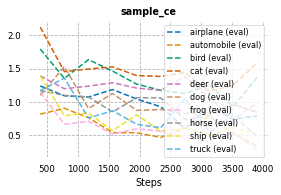

FastEstimator-Finish: step: 3910; model1_lr: 0.001; total_time: 213.74 sec;


In [7]:
estimator.fit()

From the graph above it seems that cats are relatively difficult for the network to learn well, whereas automobiles are pretty easy.

<a id='ta08instance'></a>

## Instance Tracking

Suppose you are doing some training, and you want to know which samples from your dataset are the most difficult to learn. Perhaps they were mislabeled, for example. Let's suppose you're also very curious about how well sample 10 and sample 18 from your training data do over time. One way to investigate this is with the `InstanceTracker` `Trace`. It takes as input any per-element metric (such as sample-wise loss), as well as an index vector and produces a visualization at the end of training:

In [8]:
batch_size=128
save_dir = tempfile.mkdtemp()

train_data, eval_data = cifair10.load_data()
test_data = eval_data.split(range(len(eval_data) // 2))

train_data['index'] = np.array([i for i in range(len(train_data))], dtype=np.int).reshape((len(train_data), 1))

pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
         PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
         RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
         Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
         CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1),
         ],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="sample_ce", average_loss=False),
    LambdaOp(inputs="sample_ce", outputs="ce", fn=lambda x: reduce_mean(x)),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    MCC(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="mcc", save_best_mode="max", load_best_final=True),
    InstanceTracker(index="index", metric="sample_ce", n_max_to_keep=5, n_min_to_keep=0, list_to_keep=[10, 18], outputs="ce_vs_idx", mode="train"),
    ImageViewer(inputs="ce_vs_idx", mode="train")
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=10,
                         traces=traces,
                         log_steps=300)

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 300; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.3158417;
FastEstimator-Train: step: 300; ce: 1.4950535; steps/sec: 19.04;
FastEstimator-Train: step: 391; epoch: 1; epoch_time: 21.03 sec;
FastEstimator-BestModelSaver: Saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpwd24sr43/model2_best_mcc.h5
FastEstimator-Eval: step: 391; epoch: 1; ce: 1.3292162; max_mcc: 0.4703703798138759; mcc: 0.4703703798138759; since_best_mcc: 0;
FastEstimator-Train: step: 600; ce: 1.2212611; steps/sec: 18.63;

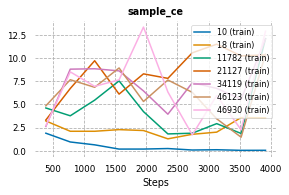

FastEstimator-Finish: step: 3910; model2_lr: 0.001; total_time: 218.06 sec;


In [9]:
estimator.fit()

From the graph above it looks like datapoint number 10 is pretty easy, whereas 18 is somewhat difficult. Performance on some of the hardest points actually seems to get worse over time, so perhaps it would be worth visualizing them to see if there's a reason the network is having a hard time. Let's take a look at 21127, for example:

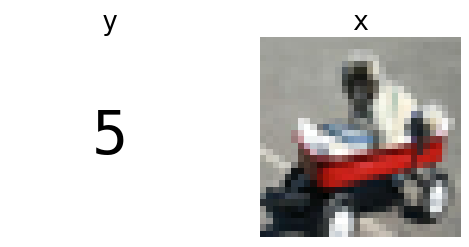

In [10]:
images = fe.util.ImgData(y=train_data[21127]['y'], x=np.expand_dims(train_data[21127]["x"], 0))
fig = images.paint_figure()
plt.show()

So we've got an image of a dog, but the network is probably looking at the wheels of the cart and guessing that this is an automobile or a truck. If you're trying to expand your dataset this could provide some useful information about what sort of images you might need to collect in order to get a more robust network.